# Combined Training Results Visualization

This notebook compares the two training runs:
- **230126**: Baseline GPT-2 reproduction
- **050226**: Improved version with RoPE, SwiGLU, and RMSNorm

Loading logs/log124M_40B_230126/01/26/log.txt...
gpt-2 (baseline):
  hella: 78 entries
  train: 19073 entries
  val: 78 entries

Loading logs/log124M_050226/log.txt...
gpt-improved (RoPE + SwiGLU):
  hella: 78 entries
  train: 38146 entries
  val: 78 entries



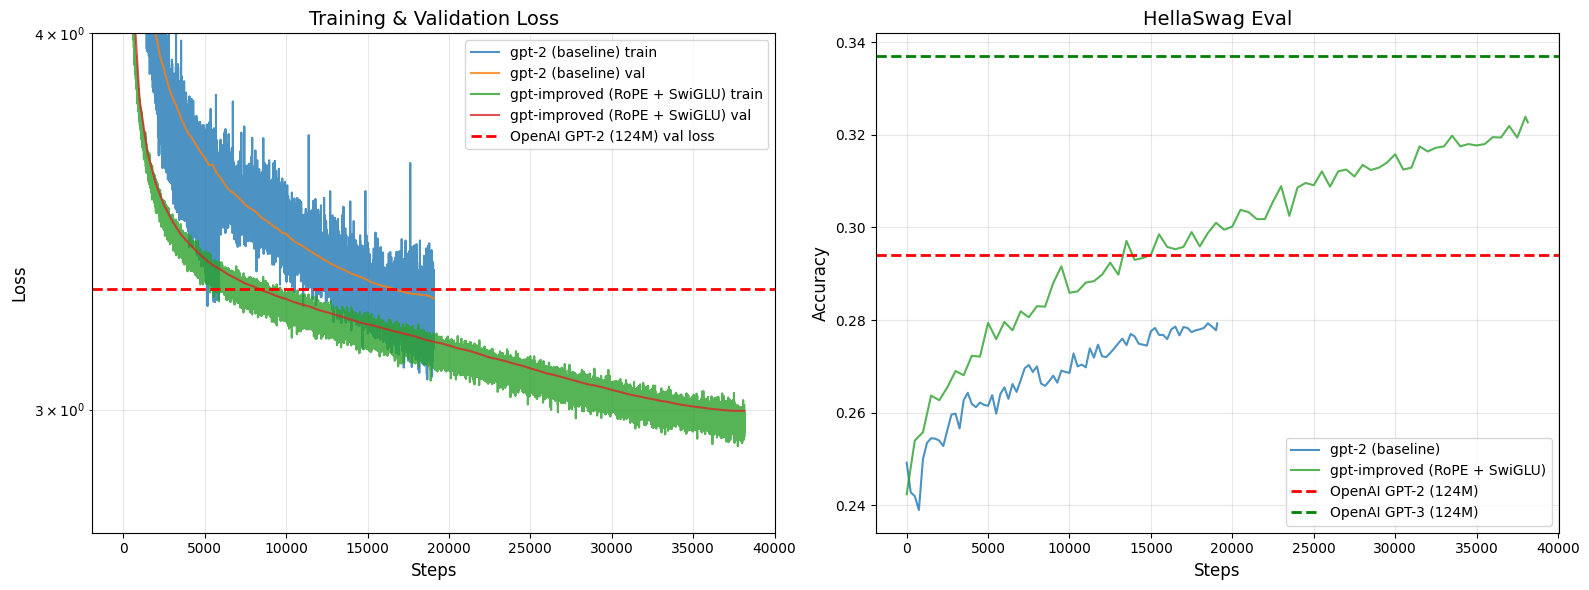

In [7]:
# parse and visualize the logfile - Combined version for both runs
import numpy as np
import matplotlib.pyplot as plt

sz = "124M"

loss_baseline = {
    # https://github.com/openai/gpt-2/blob/master/model_card.md
    "124M": 3.29,
    "350M": 2.90,
    "774M": 2.70,
    "1558M": 2.60,
}[sz]

hella2_baseline = {
    # https://github.com/openai/gpt-2/blob/master/model_card.md
    "124M": 0.294,
    "350M": 0.430,
    "774M": 0.485,
    "1558M": 0.638,
}[sz]

hella3_baseline = {
    # https://github.com/huggingface/transformers/tree/main/examples/pytorch/language-modeling (Table 2)
    "124M": 0.337,
    "350M": 0.436,
    "774M": 0.511,
    "1558M": 0.598,
}[sz]

# Define log files to load
log_files = {
    "gpt-2 (baseline)": "logs/log124M_40B_230126/01/26/log.txt",
    "gpt-improved (RoPE + SwiGLU)": "logs/log124M_050226/log.txt"
}

# Load and parse both log files
all_runs = {}
for run_name, log_path in log_files.items():
    print(f"Loading {log_path}...")
    with open(log_path, "r") as f:
        lines = f.readlines()
    
    # parse the individual lines, group by stream (train,val,hella)
    streams = {}
    for line in lines:
        parts = line.strip().split(" ")
        if len(parts) >= 3:
            k, stream, v = parts[0], parts[1], parts[2]
            if stream not in streams:
                streams[stream] = {}
            streams[stream][int(k)] = float(v)
    
    all_runs[run_name] = streams
    
    # print the streams
    print(f"{run_name}:")
    for k, v in sorted(streams.items()):
        print(f"  {k}: {len(v)} entries")
    print()

# plot the streams
plt.figure(figsize=(16, 6))

# Plot 1: Loss
plt.subplot(121)

# Define colors for each run
colors = {
    "gpt-2 (baseline)": {'train': '#1f77b4', 'val': '#ff7f0e'},
    "gpt-improved (RoPE + SwiGLU)": {'train': '#2ca02c', 'val': '#d62728'}
}

for run_name, streams in all_runs.items():
    for prefix, label in [("train", "train"), ("val", "val")]:
        if prefix in streams:
            xs, ys = zip(*sorted(streams[prefix].items()))
            plt.plot(xs, ys, 
                    label=f'{run_name} {label}',
                    color=colors[run_name][prefix],
                    alpha=0.8,
                    linewidth=1.5)

if sz in ["124M"]:
    plt.axhline(y=loss_baseline, color='r', linestyle='--', 
                label=f"OpenAI GPT-2 ({sz}) val loss", linewidth=2)
plt.xlabel("Steps", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.yscale('log')
plt.grid(True, which='both', axis='both', alpha=0.3, linestyle='-')
plt.ylim(top=4.0)
plt.legend(loc='upper right', fontsize=10)
plt.title("Training & Validation Loss", fontsize=14)
plt.grid(True, alpha=0.3, axis='both') 

# Plot 2: HellaSwag
plt.subplot(122)

hella_colors = {
    "gpt-2 (baseline)": '#1f77b4',
    "gpt-improved (RoPE + SwiGLU)": '#2ca02c'
}

for run_name, streams in all_runs.items():
    if "hella" in streams:
        xs, ys = zip(*sorted(streams["hella"].items()))
        plt.plot(xs, ys, 
                label=f"{run_name}",
                color=hella_colors[run_name],
                alpha=0.8,
                linewidth=1.5)

if sz in ["124M"]:
    plt.axhline(y=hella2_baseline, color='r', linestyle='--', 
                label=f"OpenAI GPT-2 ({sz})", linewidth=2)
if sz in ["124M"]:
    plt.axhline(y=hella3_baseline, color='g', linestyle='--', 
                label=f"OpenAI GPT-3 ({sz})", linewidth=2)
plt.xlabel("Steps", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend(loc='lower right', fontsize=10)
plt.title("HellaSwag Eval", fontsize=14)
plt.grid(True, alpha=0.3)

plt.tight_layout()
#plt.savefig('results/combined_comparison.png', dpi=150, bbox_inches='tight')
plt.show()